# Target-making machine

This notebook is the Python interface to the Arduino code for the target-making machine.

Import packages:

In [530]:
import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

Connect to the Arduino:

In [552]:
rm = pyvisa.ResourceManager()
a = rm.open_resource('ASRL15::INSTR')
a.baud_rate = 115200
a.read_termination = "\n"

### Reading from sensors

Test connection:

In [585]:
print("Fault check:")
print("  "+a.query("f")+"\n")

print("thermocouple temperatures:")
print(a.query("t"))
print(a.query("T")+"\n")
    
print("cold junction temperatures:")
print(a.query("j"))
print(a.query("J")+"\n")

print("configuration registers:")
print(a.query("c"))
print(a.query("C"))

Fault check:
  FAULT:0 FAULT:1

thermocouple temperatures:
00000011 10110100 11000000 
00000101 01011110 11100000 

cold junction temperatures:
00011111 11001100 
00100001 01010100 

configuration registers:
10000000 00000011 
10000000 01110011 


Write function for converting from returned strings to float-type temperatures:

In [554]:
def str_to_temp(temp_string, format="TC"):
    int_temp = int(temp_string.replace(" ", ""), 2)
    
    if format == "CJ":
        return int_temp * 127 / 32512
    elif format == "TC":
        return int_temp * 1000 / 4096000

Test it on real data:

In [566]:
print("Fault check:")
print("  "+a.query("f")+"\n")

print("thermocouple temperatures:")
print(str_to_temp(a.query("t"), "TC"))
print(str_to_temp(a.query("T"), "TC"), "\n")
    
print("cold junction temperatures:")
print(str_to_temp(a.query("j"), "CJ"))
print(str_to_temp(a.query("J"), "CJ"))

Fault check:
  FAULT:0 FAULT:1

thermocouple temperatures:
59.0625
87.7109375 

cold junction temperatures:
29.5625
30.34375


Measure temperature for some time:

In [597]:
raw_data = []
for i in tqdm_notebook(range(1000)):
    raw_data.append([
        time.time(),
        str_to_temp(a.query("t"), "TC"),
        str_to_temp(a.query("T"), "TC"),
        str_to_temp(a.query("j"), "CJ"),
        str_to_temp(a.query("J"), "CJ"),
    ])
    
    time.sleep(0.020)

Plot the acquired data:

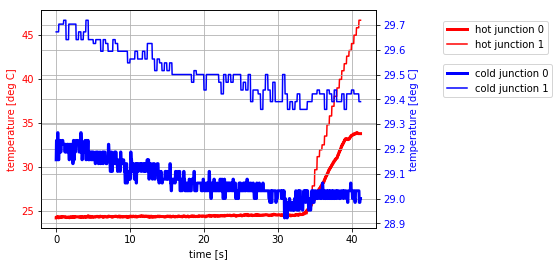

In [609]:
# get data
data = np.array(raw_data).T
data[0] -= data[0][0]

# setup plot axes
fig, ax1 = plt.subplots()
hot, cold = "red", "blue"
ax1.tick_params(axis='y', labelcolor=hot)
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor=cold)

# plot data
ax1.plot(data[0], data[1], label="hot junction 0", color=hot, lw=3)
ax1.plot(data[0], data[2], label="hot junction 1", color=hot)
ax2.plot(data[0], data[3], label="cold junction 0", color=cold, lw=3)
ax2.plot(data[0], data[4], label="cold junction 1", color=cold)

# plot labels
ax1.set_xlabel("time [s]")
ax1.set_ylabel("temperature [deg C]", color=hot)
ax2.set_ylabel("temperature [deg C]", color=cold)

# plot format
ax1.legend(loc=(1.2,.8))
ax2.legend(loc=(1.2,.6))
ax1.grid()
ax2.grid()

### Writing to sensors

Test the function for writing to MAX31856 configuration registers:

In [584]:
a.write_raw(b"w" + bytes(bytearray([0b10000000, 0b00000011])));
a.write_raw(b"W" + bytes(bytearray([0b10000000, 0b01110011])));

Close the connection:

In [550]:
a.close()